In [61]:
import pydicom
import os
import numpy
import vtk
from vtk.util import numpy_support
from matplotlib import pyplot, cm
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_adaptive, try_all_threshold 
%matplotlib inline  

In [12]:
PathDicom = "/Users/BlauBear/Documents/HS699/SE000001"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

In [13]:
# Get ref file
RefDs = pydicom.read_file(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

In [14]:
x = numpy.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = numpy.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = numpy.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

In [15]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = numpy.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  

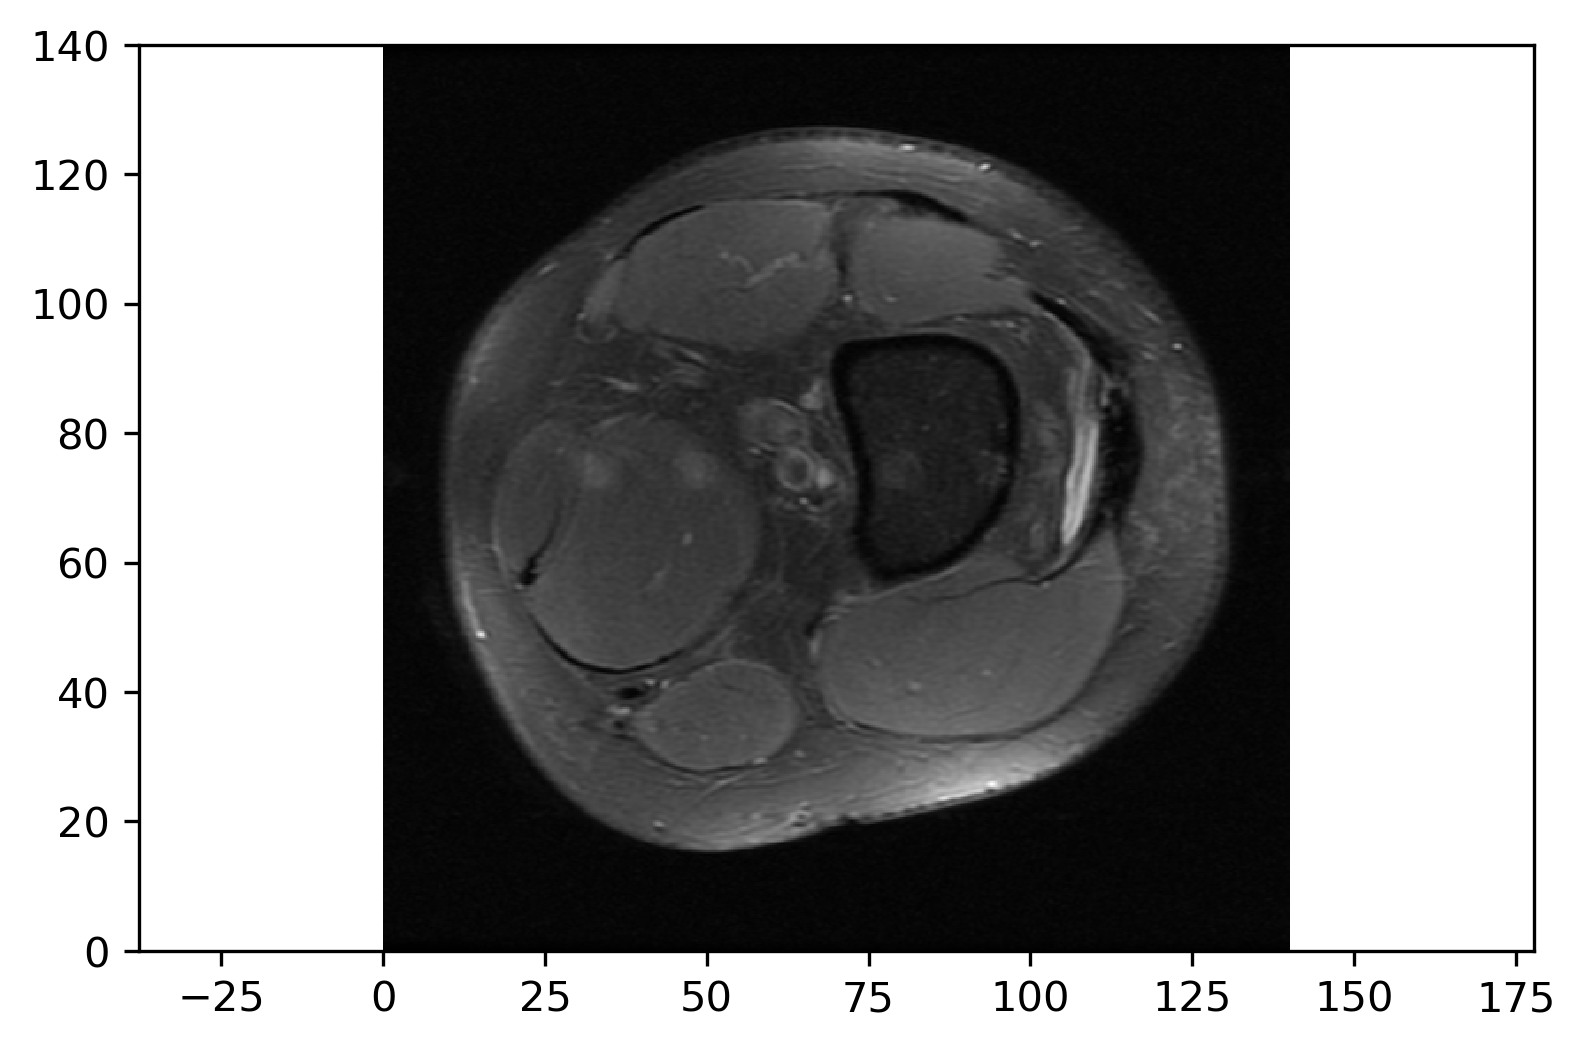

In [27]:
pyplot.figure(dpi=300)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, numpy.flipud(ArrayDicom[:, :, 0]))

In [17]:
PathDicom = "/Users/BlauBear/Documents/HS699/SE000001"
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(PathDicom)
reader.Update()

In [18]:
# Load dimensions using `GetDataExtent`
_extent = reader.GetDataExtent()
ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]

# Load spacing values
ConstPixelSpacing = reader.GetPixelSpacing()

In [19]:
# Get the 'vtkImageData' object from the reader
imageData = reader.GetOutput()
# Get the 'vtkPointData' object from the 'vtkImageData' object
pointData = imageData.GetPointData()
# Ensure that only one array exists within the 'vtkPointData' object
assert (pointData.GetNumberOfArrays()==1)
# Get the `vtkArray` (or whatever derived type) which is needed for the `numpy_support.vtk_to_numpy` function
arrayData = pointData.GetArray(0)

In [53]:
# Convert the `vtkArray` to a NumPy array
ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
# Reshape the NumPy array to 3D using 'ConstPixelDims' as a 'shape'
ArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')

In [54]:
ArrayDicom[:,:,0].shape

(512, 512)

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


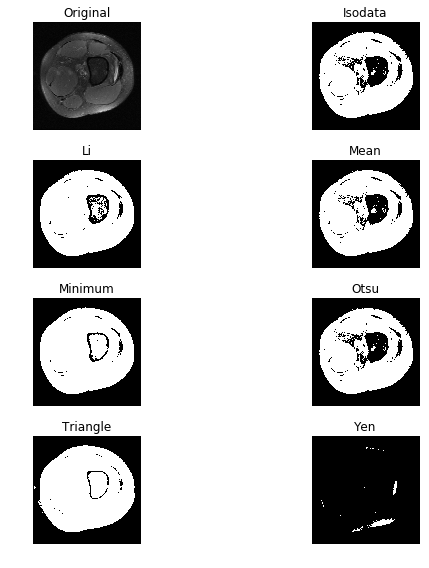

In [62]:
fig, ax = try_all_threshold(ArrayDicom[:,:,0], figsize=(10, 8), verbose=False)
plt.show()

In [55]:
global_thresh = threshold_otsu(ArrayDicom[:,:,0])
binary_global = ArrayDicom[:,:,0] > global_thresh

In [59]:
block_size = 512
binary_adaptive = threshold_adaptive(ArrayDicom[:,:,0], block_size, method='gaussian', offset=0)

/usr/local/anaconda3/lib/python3.6/site-packages/skimage/filters/thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
/usr/local/anaconda3/lib/python3.6/site-packages/skimage/filters/thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '


ValueError: The kwarg ``block_size`` must be odd! Given ``block_size`` 512 is even.

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
ax0, ax1, ax2 = axes
plt.gray()

In [ ]:
ax0.imshow(ArrayDicom[:,:,0])
ax0.set_title('Dicom')

In [ ]:
ax1.imshow(binary_global)
ax1.set_title('Global thresholding')

In [ ]:
ax2.imshow(binary_adaptive)
ax2.set_title('Adaptive thresholding')

In [ ]:
for ax in axes:
    ax.axis('off')

In [ ]:
plt.show()